##submitted by Alarmelu Pichu Mani
email: alarmelu.pm@gmail.com

# Developing a toxic comment classifier using NLP techniques and basic ML classifiers

In [6]:
#imports needed to build the classifier
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import re 
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

# Importing the data 

In [7]:
df_in = pd.read_csv('train.csv')
df_in.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [8]:
df_in.head(100)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
95,003b9f448ee4a29d,"""\n\nThanks. I can see that violating clearly ...",0,0,0,0,0,0
96,003bd094feef5263,"""\nHi\nThanks for our kind words. See you arou...",0,0,0,0,0,0
97,003caacc6ce6c9e9,Collusion in poker \n\nThis is regarded as mos...,0,0,0,0,0,0
98,003d77a20601cec1,"Thanks much - however, if it's been resolved, ...",0,0,0,0,0,0


In [9]:
df_in['comment_text'][4]

"You, sir, are my hero. Any chance you remember what page that's on?"

In [10]:
df_in['comment_text'][95]

'"\n\nThanks. I can see that violating clearly stated Wikipedia policy is no problem with some people, as is now being reviewed elsewhere. Finishing up one other wiki project todsy and then spending the rest of the day on an important personal blog entry.  Then I\'ll go find other discussions of James Petras\' fascinating discussion of the use of the term ""Jewish Lobby"" so that I don\'t have to put back up the deleted Dissident Voice article right away per Talk:Jewish_lobby#WP:V_-_comparing_Jewish_Virtual_Library_and_Dissident_Voice.\nCarol Moore  talk"'

In [11]:
df_in['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

## Exploratory analysis

Analyzing each class to see how the distribution is 

In [100]:
types=[] #to capture the classes present in the data set
toxicity = df_in.iloc[:,2:]
for colname, col in toxicity.iteritems():
    print('Column name: ',colname)
    types.append(colname)
    toxicity_percent = df_in[colname].value_counts(normalize=True)
    print(toxicity_percent)
types

Column name:  toxic
0    0.904156
1    0.095844
Name: toxic, dtype: float64
Column name:  severe_toxic
0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64
Column name:  obscene
0    0.947052
1    0.052948
Name: obscene, dtype: float64
Column name:  threat
0    0.997004
1    0.002996
Name: threat, dtype: float64
Column name:  insult
0    0.950636
1    0.049364
Name: insult, dtype: float64
Column name:  identity_hate
0    0.991195
1    0.008805
Name: identity_hate, dtype: float64


['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

<ipython-input-13-9ef9fa401aec>:11: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  source_pie = plt.pie(pie_data,labels=pie_data.index, autopct='%1.1f%%', shadow=False, colors=colors, explode=explode)


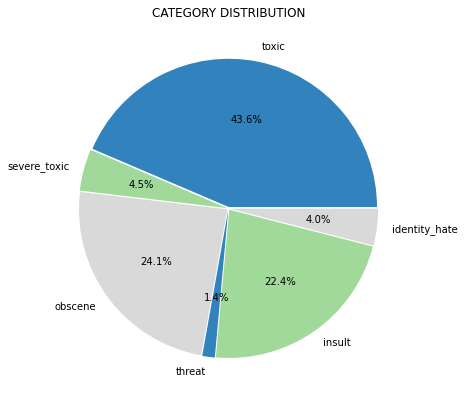

In [13]:
from matplotlib.gridspec import GridSpec
pie_data = pd.DataFrame(toxicity.sum())

# Make square figures and axes
plt.figure(1, figsize=(15,15))
the_grid = GridSpec(2, 2)
cmap = plt.get_cmap('tab20c')
explode = [0.01,0.01,0.01,0.01,0.01,0.01] 
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')
source_pie = plt.pie(pie_data,labels=pie_data.index, autopct='%1.1f%%', shadow=False, colors=colors, explode=explode)
plt.show()

The above piechart helps understand if the data set is balanced as a whole. We can see that toxic comments alone make up 43.6% of the entire dataset.
Threats are very small number. Threats, severe toxic and identity hate make up ~10% of the data set

In [14]:
print('Total number of rows: ',len(toxicity))
tox_count = toxicity.sum()
tox_count

Total number of rows:  159571


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

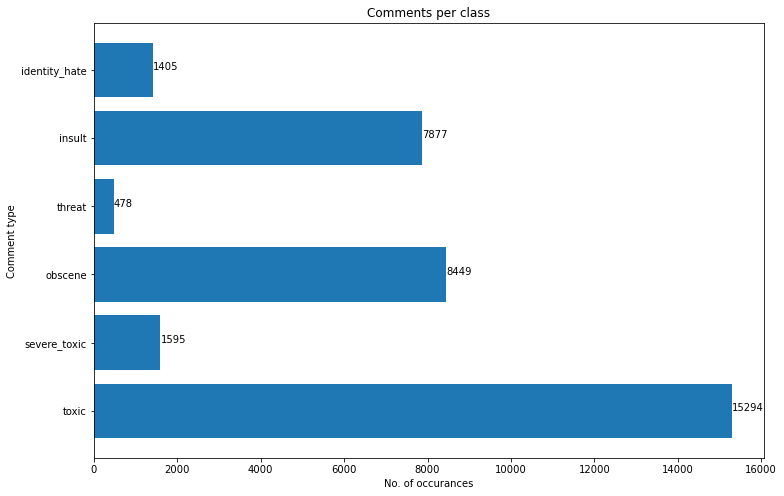

In [15]:
x = tox_count.index
y = tox_count.values
plt.figure(figsize=(12,8))
plt.barh(x, y)
plt.ylabel("Comment type")
plt.xlabel("No. of occurances")
plt.title("Comments per class")
for index, value in enumerate(y):
    plt.text(value, index, str(value))


The above barchart shows the distribution in actual number of comments under each class

# Checking if comment fall under multiple labels
Eg. Can a comment be both toxic and imply a threat?

Text(0.5, 0, '# of categories')

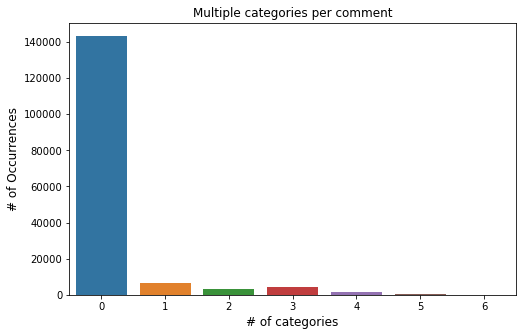

In [16]:
#Do comments have multiple labels?
rowsums = df_in.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

Here we can see that comments fall under more than one class.
There are 140000+ comments in the unlabelled category. This means that the comment can be in a category other than the 
classes in the data set - for example: positive comments

In [102]:
print('Percentage of unlabelled comments')
print(len(df_in[(df_in['toxic']==0) & (df_in['severe_toxic']==0) & (df_in['obscene']==0) & (df_in['threat']== 0) & (df_in['insult']==0) & (df_in['identity_hate']==0)]) / len(df_in))

print('Looking for missing comments in the comment_text column')
df_in['comment_text'].isnull().sum()

Percentage of unlabelled comments
0.8983211235124177
Looking for missing comments in the comment_text column


0

There are no missing comments in the comment_text column

least length:  6
maximum length:  5000


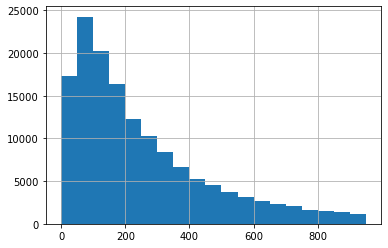

In [17]:
#Size/length of the comment
length = df_in.comment_text.str.len()
print('least length: ',min(length))
print('maximum length: ',max(length))
length.hist(bins = np.arange(0,1000,50))

The length of the comments vary anywhere between 6-5000. However the concentration of the length is between 1-200 and then it gradually decreases. 

In [30]:
import re
def clean_comments(text):
    text = text.lower()
    text = re.sub('http\S+\s*', ' ', text)  # remove URLs
    text = re.sub('RT|cc', ' ', text)  # remove RT and cc
    text = re.sub('#\S+', '', text)  # remove hashtags
    text = re.sub('@\S+', '  ', text)  # remove mentions
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', text)  # remove punctuations
    text = re.sub(r'[^\x00-\x7f]',r' ', text)  #remove non-ascii characters
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    return text

In [31]:
df_in['comment_text']=df_in.comment_text.apply(lambda x: clean_comments(x))

In [32]:
df_in['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now 89 205 38 27'

In [33]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df_in['comment_text']=df_in.comment_text.apply(lambda x: lemmatizer.lemmatize(x))


# Balancing the dataset

Balancing the dataset
As mentioned earlier, since our dataset is not very balanced. 
We need to manually balance the dataset to get good results from the classifiers.

Separating the dataset into 6 sections based on the classes

In [35]:
data_tox = df_in.loc[:,['id','comment_text','toxic']]
data_sev = df_in.loc[:,['id','comment_text','severe_toxic']]
data_obs = df_in.loc[:,['id','comment_text','obscene']]
data_thr = df_in.loc[:,['id','comment_text','threat']]
data_ins = df_in.loc[:,['id','comment_text','insult']]
data_ide = df_in.loc[:,['id','comment_text','identity_hate']]

Examining the toxic comments to understand the distribution.
In total there are 15294 rows of data in the toxic class,
In order to have a balanced dataset, we take only 5000 toxic comments and 5000 comments that may fall under any of the other categories

In [105]:
df_tox1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
df_tox0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]
df_tox = pd.concat([df_tox1, df_tox0], axis=0)

Likewise for severe toxic comments, where there are only 1595 rows.

In [37]:
data_sev[data_sev['severe_toxic'] == 1].count()

id              1595
comment_text    1595
severe_toxic    1595
dtype: int64

In [38]:
df_sev1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
df_sev0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
df_sev = pd.concat([df_sev1, df_sev0], axis=0)

As for the obscene comments, we stick to 5000 rows again

In [39]:
data_obs[data_obs['obscene'] == 1].count()

id              8449
comment_text    8449
obscene         8449
dtype: int64

In [40]:
df_obs1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
df_obs0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
df_obs = pd.concat([df_obs1, df_obs0], axis=0)

Since threat is a very small part of the dataset, we make it a 20-80 data distribution 
where 80% of the data will come from other classes

In [41]:
data_thr[data_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

In [42]:
df_thr1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
df_thr0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
df_thr = pd.concat([df_thr1, df_thr0], axis=0)
df_thr.shape

(2390, 3)

In [43]:
data_ins[data_ins['insult'] == 1].count()

id              7877
comment_text    7877
insult          7877
dtype: int64

Insults are a bigger portion again, so we stick to 5000 rows and 5000 rows of other data

In [44]:
df_ins1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
df_ins0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
df_ins = pd.concat([df_ins1, df_ins0], axis=0)
df_ins.shape

(10000, 3)

In [45]:
data_ide[data_ide['identity_hate'] == 1].count()

id               1405
comment_text     1405
identity_hate    1405
dtype: int64

As for identity hate, we follow the 20-80 model where 80% comes from other classes of comments

In [46]:
df_ide1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
df_ide0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
df_ide = pd.concat([df_ide1, df_ide0], axis=0)
df_ide.shape

(7025, 3)

# Feeding the datasets into Machine learning algorithms for classification

The eval_tp function computes the classifier metrics for our analysis

In [47]:
def eval_tp(actual,propensity,cutoff):
    
    cm = confusion_matrix(actual,[1 if p > cutoff else 0 for p in propensity]).ravel()
    
    tn=cm[0]
    fp=cm[1]
    fn=cm[2]
    tp=cm[3]
    recall  = tp / (tp + fn)
    precision= tp / (tp + fp)
    accuracy_scor=accuracy_score(actual,[1 if p > cutoff else 0 for p in propensity])
    metrics = [recall,precision,accuracy_scor]
    return metrics

The classifier_CV classifies the comments based on the countVecorizer  term-document matrix feature.
I have used Decision tree, Logistic regression and KNN classfiers to classify the comments.
Decision tree and Logistic regression use polarly opposite methodologies to classify data.
Decision tree bisects spaces into smaller sections while logistic regression bisects the space into exactly two.
KNN classifier is not model based and would have a lower bias. Hence I added it in the mix to see if I am able to get
any insights.

Use of countVecorizer:
Since the ML models cannot process text data as it is, we need to transform our documents into vectors for the algorithm to consume and analyze.
The countVecorizer converts the text into vectors based on the word counts occuring in the entire text. This process is called feature extraction and is an essential step in applying ML algorithms to language.


In [48]:
def classifier_CV(df,types):
    # Split the data into X and y data sets
    X = df.comment_text
    y = df[types]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create a Vectorizer object and remove stopwords from the table
    cv1 = CountVectorizer(ngram_range=(1,1), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
    
    ####.......Decision Tree........####
    dt = DecisionTreeClassifier(max_depth =3, random_state = 42)
    dt.fit(X_train_cv1, y_train)
    dt_f1 = f1_score(dt.predict(X_test_cv1), y_test)
    dt_model_eval = eval_tp(actual=y_test,propensity=pd.DataFrame(dt.predict_proba(X_test_cv1)).iloc[:,1],cutoff=0.5)
    print('....... Decision Tree Results ........')
    print('....... class type {} ........'.format(types))
    print('precision: ',dt_model_eval[1])
    print('recall: ',dt_model_eval[0],'\n')
    dt_accuracy = dt_model_eval[2]
    
    ####.......Logistic Regression........####
    lr = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
    lr.fit(X_train_cv1, y_train)
    lr_f1 = f1_score(lr.predict(X_test_cv1), y_test)
    lr_model_eval = eval_tp(actual=y_test,propensity=pd.DataFrame(lr.predict_proba(X_test_cv1)).iloc[:,1],cutoff=0.5)
    print('....... Logistic Regression Results ........')
    print('....... class type {} ........'.format(types))
    print('precision: ',lr_model_eval[1])
    print('recall: ',lr_model_eval[0],'\n')
    lr_accuracy = lr_model_eval[2]
    
    ####.......KNeighbors Classifier........####
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)
    knn_f1 = f1_score(knn.predict(X_test_cv1), y_test)
    knn_model_eval = eval_tp(actual=y_test,propensity=pd.DataFrame(knn.predict_proba(X_test_cv1)).iloc[:,1],cutoff=0.5)
    print('....... KNeighbors Classifier Results ........')
    print('....... class type {} ........'.format(types))
    print('precision: ',knn_model_eval[1])
    print('recall: ',knn_model_eval[0],'\n')
    knn_accuracy = knn_model_eval[2]
    
    #####.......collating the results........####
    models = ['Decision Tree','Log. Regression','KNN']
    f1_scores = [dt_f1,lr_f1,knn_f1]
    accuracy_scores = [dt_accuracy,lr_accuracy,knn_accuracy]
    df_metrics = pd.DataFrame({'Models': models, 'F1 scores': f1_scores,'Accuracy Scores':accuracy_scores})
    df_metrics.set_index("Models", inplace = True)
    return df_metrics

    

In [49]:
types

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [73]:
###........Evaluating toxic comments........###
toxic_metrics = classifier_CV(df_tox,'toxic')
toxic_metrics.rename(columns={'F1 scores':'F1 Scores(toxic)'}, inplace=True)
toxic_metrics.rename(columns={'Accuracy Scores':'Accuracy Scores(toxic)'}, inplace=True)
toxic_metrics

....... Decision Tree Results ........
....... class type toxic ........
precision:  0.9918032786885246
recall:  0.236174365647365 

....... Logistic Regression Results ........
....... class type toxic ........
precision:  0.8949175824175825
recall:  0.8477553675992192 

....... KNeighbors Classifier Results ........
....... class type toxic ........
precision:  0.6852367688022284
recall:  0.8002602472348731 



,F1 Scores(toxic),Accuracy Scores(toxic)
Models,,
Decision Tree,0.381503,0.607667
Log. Regression,0.870698,0.871000
KNN,0.738295,0.709333


In [74]:
###........Evaluating severe toxic comments........###
sevtoxic_metrics = classifier_CV(df_sev,'severe_toxic')
sevtoxic_metrics.rename(columns={'F1 scores':'F1 Scores(severe_toxic)'}, inplace=True)
sevtoxic_metrics.rename(columns={'Accuracy Scores':'Accuracy Scores(severe_toxic)'}, inplace=True)
sevtoxic_metrics

....... Decision Tree Results ........
....... class type severe_toxic ........
precision:  0.9648562300319489
recall:  0.6278586278586279 

....... Logistic Regression Results ........
....... class type severe_toxic ........
precision:  0.9576837416481069
recall:  0.893970893970894 

....... KNeighbors Classifier Results ........
....... class type severe_toxic ........
precision:  0.7441471571906354
recall:  0.9251559251559252 



,F1 Scores(severe_toxic),Accuracy Scores(severe_toxic)
Models,,
Decision Tree,0.760705,0.801463
Log. Regression,0.924731,0.926855
KNN,0.824838,0.802508


In [75]:
###........Evaluating obscene comments........###
obscene_metrics = classifier_CV(df_obs,'obscene')
obscene_metrics.rename(columns={'F1 scores':'F1 Scores(obscene)'}, inplace=True)
obscene_metrics.rename(columns={'Accuracy Scores':'Accuracy Scores(obscene)'}, inplace=True)
obscene_metrics

....... Decision Tree Results ........
....... class type obscene ........
precision:  0.9880794701986755
recall:  0.4853610930383865 

....... Logistic Regression Results ........
....... class type obscene ........
precision:  0.955617198335645
recall:  0.896551724137931 

....... KNeighbors Classifier Results ........
....... class type obscene ........
precision:  0.6500685244403838
recall:  0.9258295380611581 



,F1 Scores(obscene),Accuracy Scores(obscene)
Models,,
Decision Tree,0.650960,0.733333
Log. Regression,0.925143,0.925667
KNN,0.763822,0.706667


In [76]:
###........Evaluating threat comments........###
threat_metrics = classifier_CV(df_thr,'threat')
threat_metrics.rename(columns={'F1 scores':'F1 Scores(threat)'}, inplace=True)
threat_metrics.rename(columns={'Accuracy Scores':'Accuracy Scores(threat)'}, inplace=True)
threat_metrics

....... Decision Tree Results ........
....... class type threat ........
precision:  0.8901098901098901
recall:  0.525974025974026 

....... Logistic Regression Results ........
....... class type threat ........
precision:  0.8402777777777778
recall:  0.7857142857142857 

....... KNeighbors Classifier Results ........
....... class type threat ........
precision:  0.6774193548387096
recall:  0.5454545454545454 



,F1 Scores(threat),Accuracy Scores(threat)
Models,,
Decision Tree,0.661224,0.884240
Log. Regression,0.812081,0.921897
KNN,0.604317,0.846583


In [77]:
###........Evaluating insult comments........###
insult_metrics = classifier_CV(df_ins,'insult')
insult_metrics.rename(columns={'F1 scores':'F1 Scores(insult)'}, inplace=True)
insult_metrics.rename(columns={'Accuracy Scores':'Accuracy Scores(insult)'}, inplace=True)
insult_metrics

....... Decision Tree Results ........
....... class type insult ........
precision:  0.9718574108818011
recall:  0.33702016916070265 

....... Logistic Regression Results ........
....... class type insult ........
precision:  0.9291121816930489
recall:  0.878334417696812 

....... KNeighbors Classifier Results ........
....... class type insult ........
precision:  0.7315242494226328
recall:  0.8243331164606376 



,F1 Scores(insult),Accuracy Scores(insult)
Models,,
Decision Tree,0.500483,0.655333
Log. Regression,0.903010,0.903333
KNN,0.775161,0.755000


In [78]:
###........Evaluating identity hate comments........###
idhate_metrics = classifier_CV(df_ide,'identity_hate')
idhate_metrics.rename(columns={'F1 scores':'F1 Scores(identity_hate)'}, inplace=True)
idhate_metrics.rename(columns={'Accuracy Scores':'Accuracy Scores(identity_hate)'}, inplace=True)
idhate_metrics

....... Decision Tree Results ........
....... class type identity_hate ........
precision:  0.875
recall:  0.46136363636363636 

....... Logistic Regression Results ........
....... class type identity_hate ........
precision:  0.8154897494305239
recall:  0.8136363636363636 

....... KNeighbors Classifier Results ........
....... class type identity_hate ........
precision:  0.7088948787061995
recall:  0.5977272727272728 



,F1 Scores(identity_hate),Accuracy Scores(identity_hate)
Models,,
Decision Tree,0.604167,0.873814
Log. Regression,0.814562,0.922676
KNN,0.648582,0.864801


In [79]:
all_metrics = pd.concat([toxic_metrics,sevtoxic_metrics,obscene_metrics,threat_metrics,insult_metrics,idhate_metrics],axis=1)

In [80]:
f1= ['F1 Scores(toxic)', 'F1 Scores(severe_toxic)','F1 Scores(obscene)','F1 Scores(threat)','F1 Scores(insult)','F1 Scores(identity_hate)']
acc = ['Accuracy Scores(toxic)','Accuracy Scores(severe_toxic)','Accuracy Scores(obscene)','Accuracy Scores(threat)',
        'Accuracy Scores(insult)','Accuracy Scores(identity_hate)']


In [84]:
f1_scores_CV = all_metrics[f1].transpose()
f1_scores_CV

Models,Decision Tree,Log. Regression,KNN
F1 Scores(toxic),0.381503,0.870698,0.738295
F1 Scores(severe_toxic),0.760705,0.924731,0.824838
F1 Scores(obscene),0.650960,0.925143,0.763822
F1 Scores(threat),0.661224,0.812081,0.604317
F1 Scores(insult),0.500483,0.903010,0.775161
F1 Scores(identity_hate),0.604167,0.814562,0.648582


In [85]:
acc_scores_CV = all_metrics[acc].transpose()
acc_scores_CV

Models,Decision Tree,Log. Regression,KNN
Accuracy Scores(toxic),0.607667,0.871000,0.709333
Accuracy Scores(severe_toxic),0.801463,0.926855,0.802508
Accuracy Scores(obscene),0.733333,0.925667,0.706667
Accuracy Scores(threat),0.884240,0.921897,0.846583
Accuracy Scores(insult),0.655333,0.903333,0.755000
Accuracy Scores(identity_hate),0.873814,0.922676,0.864801


## Use of TF-IDF vectorizer
countVectorizer can bias the model in favor of most frequent words in a document.
TfidfVectorizer overcomes this shortcoming of countVectorizer and considers the overall document weightage of a word.
This can help improve accuracies especilly for classification models

In [86]:
def classifier_TFIDF(df,types):
    # Split the data into X and y data sets
    X = df.comment_text
    y = df[types]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create a Vectorizer object and remove stopwords from the table
    cv1 = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
    
    ####.......Decision Tree........####
    dt = DecisionTreeClassifier(max_depth =3, random_state = 42)
    dt.fit(X_train_cv1, y_train)
    dt_f1 = f1_score(dt.predict(X_test_cv1), y_test)
    dt_model_eval = eval_tp(actual=y_test,propensity=pd.DataFrame(dt.predict_proba(X_test_cv1)).iloc[:,1],cutoff=0.5)
    print('....... Decision Tree Results ........')
    print('....... class type {} ........'.format(types))
    print('precision: ',dt_model_eval[1])
    print('recall: ',dt_model_eval[0],'\n')
    dt_accuracy = dt_model_eval[2]
    
    ####.......Logistic Regression........####
    lr = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
    lr.fit(X_train_cv1, y_train)
    lr_f1 = f1_score(lr.predict(X_test_cv1), y_test)
    lr_model_eval = eval_tp(actual=y_test,propensity=pd.DataFrame(lr.predict_proba(X_test_cv1)).iloc[:,1],cutoff=0.5)
    print('....... Logistic Regression Results ........')
    print('....... class type {} ........'.format(types))
    print('precision: ',lr_model_eval[1])
    print('recall: ',lr_model_eval[0],'\n')
    lr_accuracy = lr_model_eval[2]
    
    ####.......KNeighbors Classifier........####
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)
    knn_f1 = f1_score(knn.predict(X_test_cv1), y_test)
    knn_model_eval = eval_tp(actual=y_test,propensity=pd.DataFrame(knn.predict_proba(X_test_cv1)).iloc[:,1],cutoff=0.5)
    print('....... KNeighbors Classifier Results ........')
    print('....... class type {} ........'.format(types))
    print('precision: ',knn_model_eval[1])
    print('recall: ',knn_model_eval[0],'\n')
    knn_accuracy = knn_model_eval[2]
    
    #####.......collating the results........####
    models = ['Decision Tree','Log. Regression','KNN']
    f1_scores = [dt_f1,lr_f1,knn_f1]
    accuracy_scores = [dt_accuracy,lr_accuracy,knn_accuracy]
    df_metrics = pd.DataFrame({'Models': models, 'F1 scores': f1_scores,'Accuracy Scores':accuracy_scores})
    df_metrics.set_index("Models", inplace = True)
    return df_metrics

    

In [67]:
###........Evaluating toxic comments........###
toxic_metrics = classifier_TFIDF(df_tox,'toxic')
toxic_metrics.rename(columns={'F1 scores':'F1 Scores(toxic)'}, inplace=True)
toxic_metrics.rename(columns={'Accuracy Scores':'Accuracy Scores(toxic)'}, inplace=True)
toxic_metrics

###........Evaluating severe toxic comments........###
sevtoxic_metrics = classifier_TFIDF(df_sev,'severe_toxic')
sevtoxic_metrics.rename(columns={'F1 scores':'F1 Scores(severe_toxic)'}, inplace=True)
sevtoxic_metrics.rename(columns={'Accuracy Scores':'Accuracy Scores(severe_toxic)'}, inplace=True)
sevtoxic_metrics

###........Evaluating obscene comments........###
obscene_metrics = classifier_TFIDF(df_obs,'obscene')
obscene_metrics.rename(columns={'F1 scores':'F1 Scores(obscene)'}, inplace=True)
obscene_metrics.rename(columns={'Accuracy Scores':'Accuracy Scores(obscene)'}, inplace=True)
obscene_metrics

###........Evaluating threat comments........###
threat_metrics = classifier_TFIDF(df_thr,'threat')
threat_metrics.rename(columns={'F1 scores':'F1 Scores(threat)'}, inplace=True)
threat_metrics.rename(columns={'Accuracy Scores':'Accuracy Scores(threat)'}, inplace=True)
threat_metrics

###........Evaluating insult comments........###
insult_metrics = classifier_TFIDF(df_ins,'insult')
insult_metrics.rename(columns={'F1 scores':'F1 Scores(insult)'}, inplace=True)
insult_metrics.rename(columns={'Accuracy Scores':'Accuracy Scores(insult)'}, inplace=True)
insult_metrics

###........Evaluating identity hate comments........###
idhate_metrics = classifier_TFIDF(df_ide,'identity_hate')
idhate_metrics.rename(columns={'F1 scores':'F1 Scores(identity_hate)'}, inplace=True)
idhate_metrics.rename(columns={'Accuracy Scores':'Accuracy Scores(identity_hate)'}, inplace=True)
#idhate_metrics

....... Decision Tree Results ........
....... class type toxic ........
precision:  0.9918032786885246
recall:  0.236174365647365 

....... Logistic Regression Results ........
....... class type toxic ........
precision:  0.9043909348441926
recall:  0.8308392973324659 

....... KNeighbors Classifier Results ........
....... class type toxic ........
precision:  0.670393777345649
recall:  0.8972023422251139 

....... Decision Tree Results ........
....... class type severe_toxic ........
precision:  0.964968152866242
recall:  0.6299376299376299 

....... Logistic Regression Results ........
....... class type severe_toxic ........
precision:  0.963963963963964
recall:  0.8898128898128899 

....... KNeighbors Classifier Results ........
....... class type severe_toxic ........
precision:  0.7985989492119089
recall:  0.9480249480249481 

....... Decision Tree Results ........
....... class type obscene ........
precision:  0.9880636604774535
recall:  0.4847104749512036 

....... Logisti

In [87]:
all_metrics = pd.concat([toxic_metrics,sevtoxic_metrics,obscene_metrics,threat_metrics,insult_metrics,idhate_metrics],axis=1)

f1= ['F1 Scores(toxic)', 'F1 Scores(severe_toxic)','F1 Scores(obscene)','F1 Scores(threat)','F1 Scores(insult)','F1 Scores(identity_hate)']
acc = ['Accuracy Scores(toxic)','Accuracy Scores(severe_toxic)','Accuracy Scores(obscene)','Accuracy Scores(threat)',
        'Accuracy Scores(insult)','Accuracy Scores(identity_hate)']


In [88]:
f1_scores_TFIDF = all_metrics[f1].transpose()
f1_scores_TFIDF

Models,Decision Tree,Log. Regression,KNN
F1 Scores(toxic),0.381503,0.870698,0.738295
F1 Scores(severe_toxic),0.760705,0.924731,0.824838
F1 Scores(obscene),0.650960,0.925143,0.763822
F1 Scores(threat),0.661224,0.812081,0.604317
F1 Scores(insult),0.500483,0.903010,0.775161
F1 Scores(identity_hate),0.604167,0.814562,0.648582


In [89]:
acc_scores_TFIDF = all_metrics[acc].transpose()
acc_scores_TFIDF

Models,Decision Tree,Log. Regression,KNN
Accuracy Scores(toxic),0.607667,0.871000,0.709333
Accuracy Scores(severe_toxic),0.801463,0.926855,0.802508
Accuracy Scores(obscene),0.733333,0.925667,0.706667
Accuracy Scores(threat),0.884240,0.921897,0.846583
Accuracy Scores(insult),0.655333,0.903333,0.755000
Accuracy Scores(identity_hate),0.873814,0.922676,0.864801


## Need for F1 score and accuracy score
Accuracy score is useful when class distribution is balanced and when true positives and true negatives are more important than false negatives or false positives.

In most real-life classification problems like this one, the data may not be always balanced and false negatives or false positives can impact business, F1 score is a better measure. Hence I have shown both the metrics.


In [97]:
############## Count vectorizer results ######################

In [98]:
f1_scores_CV

Models,Decision Tree,Log. Regression,KNN
F1 Scores(toxic),0.381503,0.870698,0.738295
F1 Scores(severe_toxic),0.760705,0.924731,0.824838
F1 Scores(obscene),0.650960,0.925143,0.763822
F1 Scores(threat),0.661224,0.812081,0.604317
F1 Scores(insult),0.500483,0.903010,0.775161
F1 Scores(identity_hate),0.604167,0.814562,0.648582


In [99]:
acc_scores_CV

Models,Decision Tree,Log. Regression,KNN
Accuracy Scores(toxic),0.607667,0.871000,0.709333
Accuracy Scores(severe_toxic),0.801463,0.926855,0.802508
Accuracy Scores(obscene),0.733333,0.925667,0.706667
Accuracy Scores(threat),0.884240,0.921897,0.846583
Accuracy Scores(insult),0.655333,0.903333,0.755000
Accuracy Scores(identity_hate),0.873814,0.922676,0.864801


Text(0.5, 1.0, 'Accuracy Scores of the models - Count vectorizer')

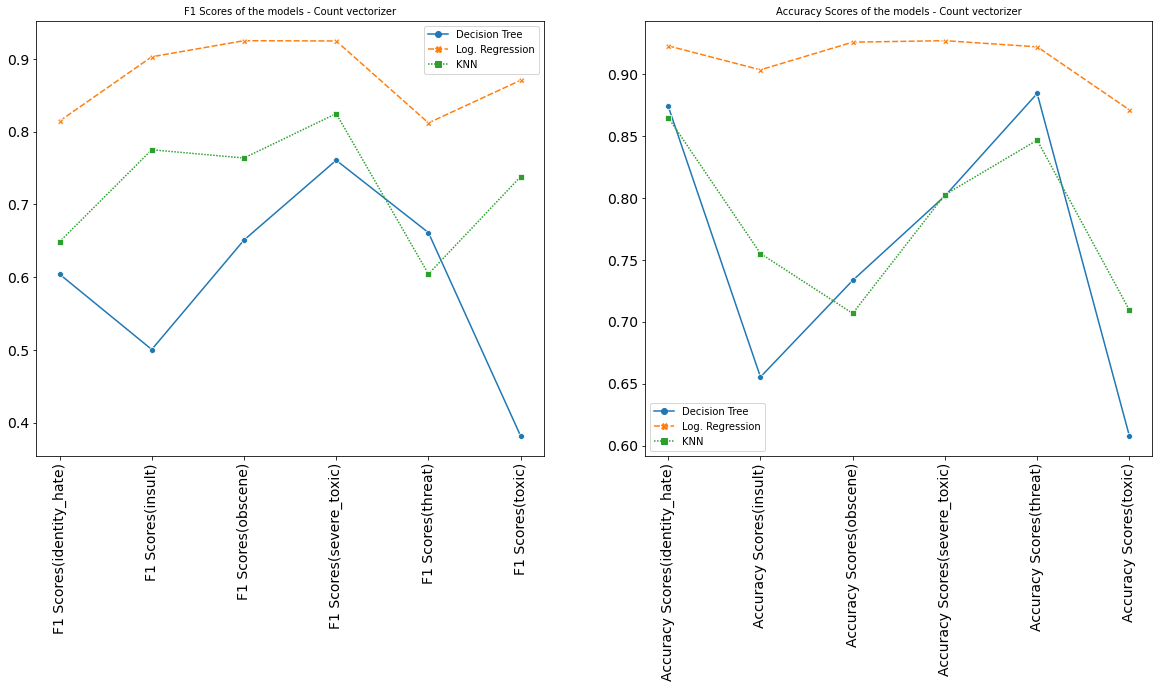

In [91]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.lineplot(data=f1_scores_CV, size=[30,20], markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Scores of the models - Count vectorizer', fontsize=10)

plt.subplot(1, 2, 2)
sns.lineplot(data=acc_scores_CV, size=[30,20], markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('Accuracy Scores of the models - Count vectorizer', fontsize=10)


In [ ]:
############## TF-IDF vectorizer results ######################

In [95]:
f1_scores_TFIDF

Models,Decision Tree,Log. Regression,KNN
F1 Scores(toxic),0.381503,0.870698,0.738295
F1 Scores(severe_toxic),0.760705,0.924731,0.824838
F1 Scores(obscene),0.650960,0.925143,0.763822
F1 Scores(threat),0.661224,0.812081,0.604317
F1 Scores(insult),0.500483,0.903010,0.775161
F1 Scores(identity_hate),0.604167,0.814562,0.648582


In [96]:
acc_scores_TFIDF

Models,Decision Tree,Log. Regression,KNN
Accuracy Scores(toxic),0.607667,0.871000,0.709333
Accuracy Scores(severe_toxic),0.801463,0.926855,0.802508
Accuracy Scores(obscene),0.733333,0.925667,0.706667
Accuracy Scores(threat),0.884240,0.921897,0.846583
Accuracy Scores(insult),0.655333,0.903333,0.755000
Accuracy Scores(identity_hate),0.873814,0.922676,0.864801


Text(0.5, 1.0, 'Accuracy Scores of the models - TFIDF vectorizer')

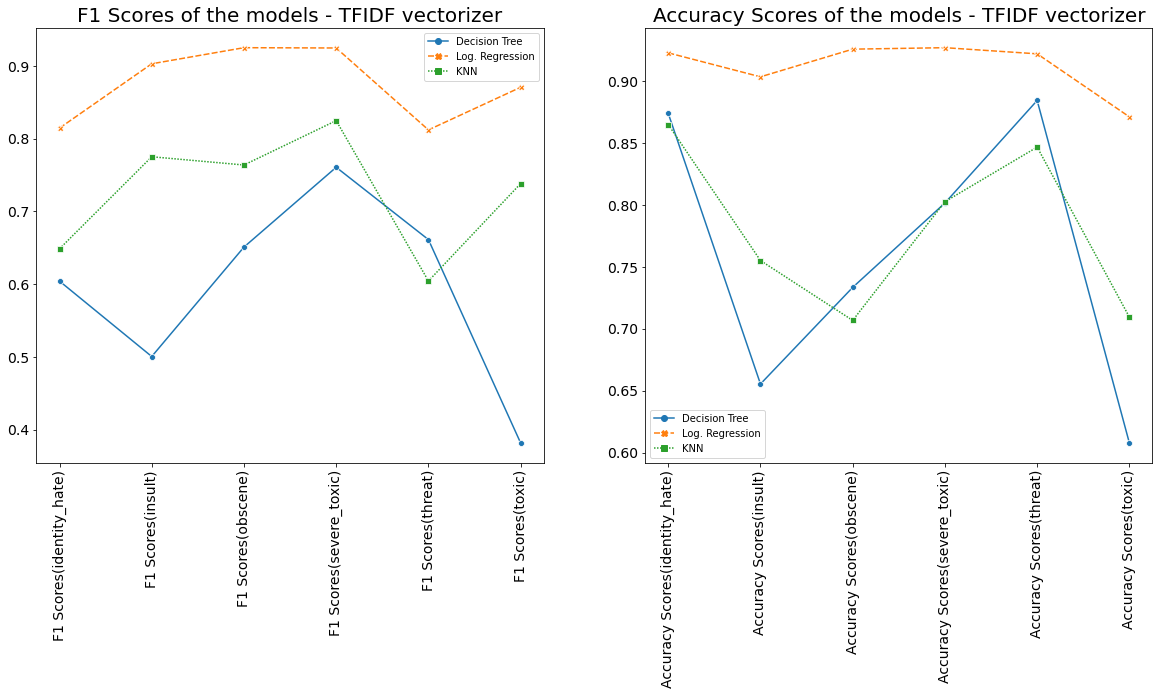

In [92]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.lineplot(data=f1_scores_TFIDF, size=[10,10], markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Scores of the models - TFIDF vectorizer', fontsize=20)

plt.subplot(1, 2, 2)
sns.lineplot(data=acc_scores_TFIDF, size=[10,10], markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('Accuracy Scores of the models - TFIDF vectorizer', fontsize=20)

From the above analysis based on both accuracy score and f1 score, Logistic regression outperforms the other 2 classifiers significantly.